In [1]:
import ldfi_py.pilp
import ldfi_py.psat
from parsing import ZipkinParser
import sys, re, os
from IPython.display import Image
from huawei_local import *


In [2]:
# put this into a library later, or borrow tuan's function

def get_label_3(data):
    svcarr = data[9].split(":")[1].split("-")
    svcarr.pop()
    return "-".join(svcarr)

def get_label_2(data):
    return data[9].split(":")[1]

def get_label_1(data):
    return data[9]

def get_label(data):
    return get_label_1(data)


# Parse the file and pick a bucket

In [4]:
trace_file = '1st_half_jan_26'
buckets = get_all_buckets(trace_file)
for key in buckets:
    print "KEY " + key + " -- " + str(len(buckets[key]))

#key = "http://127.0.0.1:8081/atswebsite/website"
key = "http://api-gateway:8080/product/product/buy/34211223411"

    

KEY http://127.0.0.1:8081/atswebsite/website -- 349
KEY http://10.154.72.17:30000/images/Huawei%20Air.png -- 1
KEY http://10.154.72.17:30000/js/acmeair-common.js -- 1
KEY http://api-gateway:8080/product/product/searchAll -- 2954
KEY http://api-gateway:8080/user/user/login -- 200
KEY http://localhost:8080/product/product/buy/34211223411 -- 1
KEY http://api-gateway:8080/product/product/buy/34211223411 -- 501


# use a rich label (service, instance, method)
# plot it

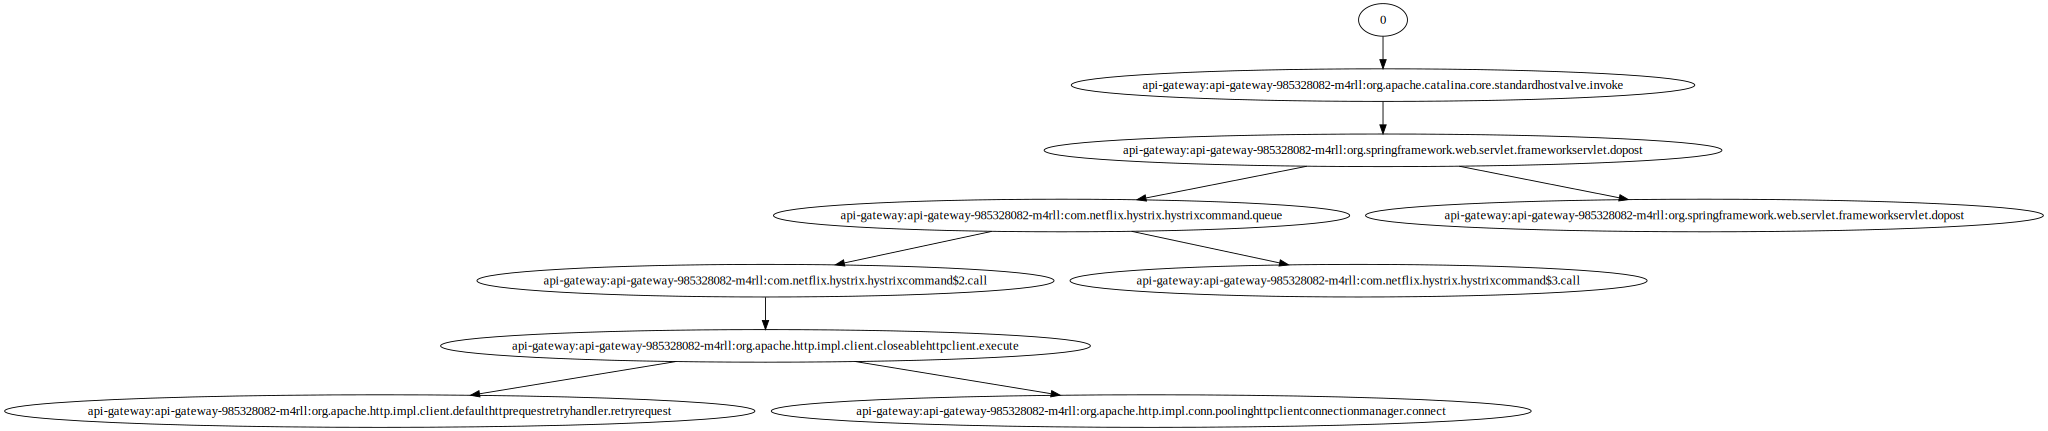

In [5]:
list(buckets[key])[0].to_dot(get_label_1)

# now solve for suggested faults

In [6]:
formula = get_formula(buckets[key], get_label_1)
cnf = CNFFormula(formula)
s = ldfi_py.pilp.Solver(cnf)
crs = s.solutions()
crs.next()

# use a less rich label (service, instance)

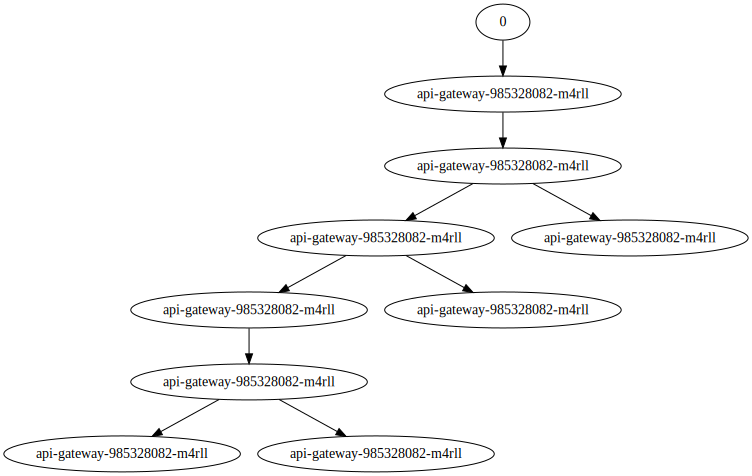

In [9]:
list(buckets[key])[0].to_dot(get_label_2)

In [16]:
formula = get_formula(buckets[key], get_label_2)
cnf = CNFFormula(formula)
s = ldfi_py.pilp.Solver(cnf)
crs = s.solutions()
crs.next()

[api_gateway_985328082_ph6p9,
 user_service_3951109029_43v9r,
 user_service_4169250386_h9flq,
 api_gateway_985328082_m4rll,
 user_service_3951109029_6cptx,
 user_service_3951109029_vz4xn,
 api_gateway_985328082_f2jc1]

In [ ]:
# truncate the instance id (service, truncated_instance_id)

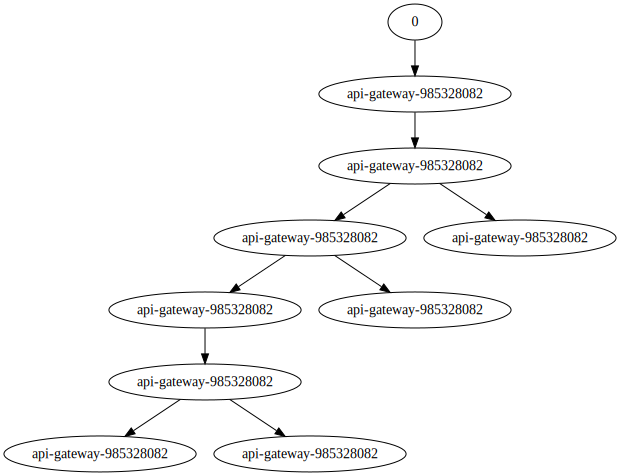

In [17]:
list(buckets[key])[0].to_dot(get_label_3)

In [18]:
formula = get_formula(buckets[key], get_label_3)
cnf = CNFFormula(formula)
s = ldfi_py.pilp.Solver(cnf)
crs = s.solutions()
crs.next()

[api_gateway_985328082, user_service_3951109029, user_service_4169250386]